In [339]:
%pylab inline
from importlib import reload
import multigpu
reload(multigpu)
import utils
reload(utils)
import numpy as np
import opt
reload(opt)
from opt import trainAndEvaluatePrimalModel, trainAndEvaluateDualModel, computeRBFGramMatrix, computeDistanceMatrix
from sklearn import metrics
import sys
import seaborn as sns
import pandas as pd
import time
from numba import jit

Populating the interactive namespace from numpy and matplotlib
/mnt/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [387]:
SEQ_SIZE = 300
NUM_GPUS = 16
ARE_YOU_SURE = True
notebook_stdout = sys.stdout
notebook_stderr = sys.stderr
terminal_stdout = open('/dev/stdout', 'w')
terminal_stderr = open('/dev/stderr', 'w')

def switch_output_to_notebook():
    sys.stdout = notebook_stdout
    sys.stderr = notebook_stdout

def switch_output_to_terminal():
    sys.stdout = terminal_stdout
    sys.stderr = terminal_stderr
    
def upweight_far_negatives(yPredTrain, yTrain, W=None, num_to_weight=100, weight=10.0):
    if W == None:
        W = np.ones((yPredTrain.shape[0], 1))
    neg_idx = np.where(yTrain == 0)[0]
    negs = yPredTrain[neg_idx]
    topk = np.argsort(negs)[-num_to_weight:]
    neg_idx[topk]
    W[neg_idx[np.argsort(negs)[-num_to_weight:]]] =  weight
    return W

@jit(nopython=True)
def generateNgrams(x, n, alpha_size=4):
    outsize = int(x.shape[0]/alpha_size - n + 1)
    ngrams = np.zeros((outsize, int(n*alpha_size)))
    for i in range(outsize):
        ngrams[i] = x[i*alpha_size:(i+n)*alpha_size]
    return ngrams


def compute_all_ngrams(X):
    all_ngrams = []
    for i in range(XTrain.shape[0]):
        ngrams = generateNgrams(XTrain[i], 8)[np.newaxis, :,:]
        all_ngrams.append(ngrams)
    return np.concatenate(all_ngrams, axis=0)
    

In [207]:

AllSeqsTrain = open("genomics_small/allTrainSeqsSampled_1000_ATF3_A549").readlines()
AllSeqsVal = open("genomics_small/allValSeqs_1000_ATF3_A549").readlines()
XSeqsTrain = list(map(lambda x: x.split(",")[0].replace("(", "")[500 - SEQ_SIZE//2: 500 + SEQ_SIZE//2], AllSeqsTrain))
XSeqsVal = list(map(lambda x: x.split(",")[0].replace("(", "")[500 - SEQ_SIZE//2: 500 + SEQ_SIZE//2], AllSeqsVal))
XTrain = utils.convertSeqToMatrix(XSeqsTrain)
XTest = utils.convertSeqToMatrix(XSeqsVal)
labelsTrain = list(map(lambda x: int(float(x.split(",")[1].replace("DenseVector(", "").replace(")", "").strip())), AllSeqsTrain))
labelsTest = list(map(lambda x: int(float(x.split(",")[1].replace("DenseVector(", "").replace(")", "").strip())), AllSeqsVal))

out = [i[0] for i in enumerate(AllSeqsTrain) if 'N' in i[1]] 
train_idxs = np.ones(XTrain.shape[0])
train_idxs[np.array(out)] = 0
XTrain = XTrain[np.where(train_idxs), :].reshape(sum(train_idxs), -1)
labelsTrain = [x[1] for x in enumerate(labelsTrain) if x[0] not in out]
yTrain = np.array(labelsTrain)
yTest = np.array(labelsTest)

/mnt/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


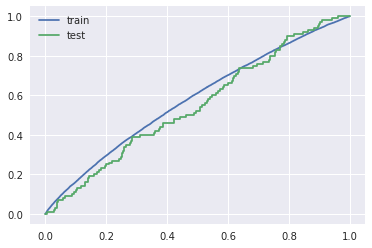

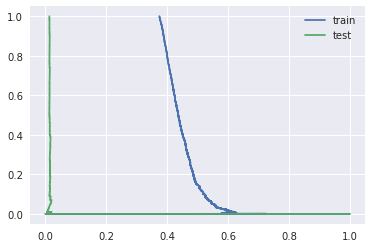

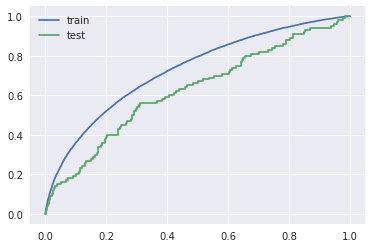

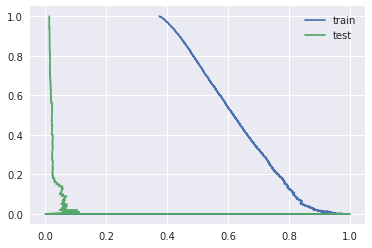

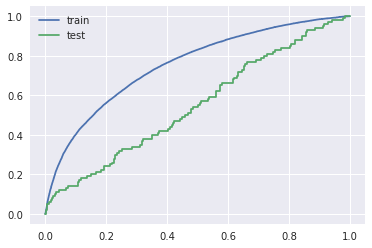

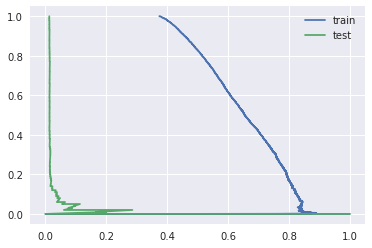

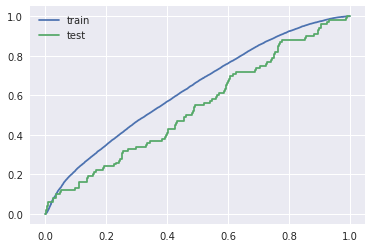

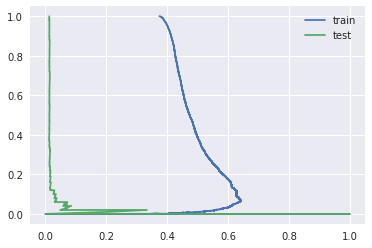

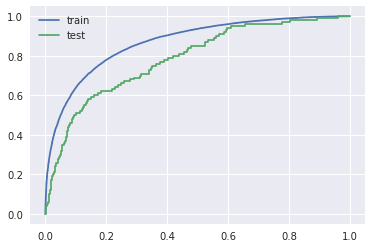

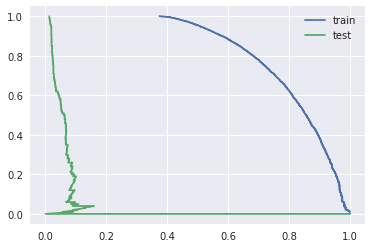

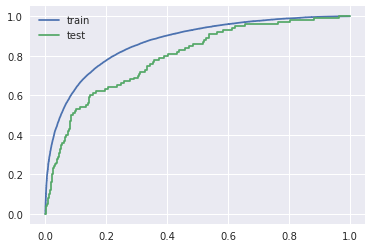

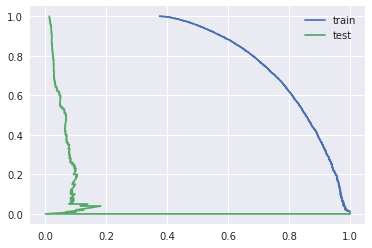

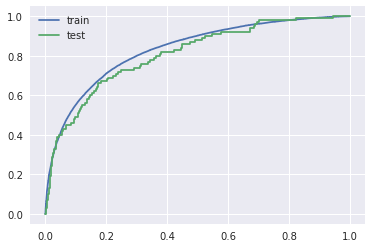

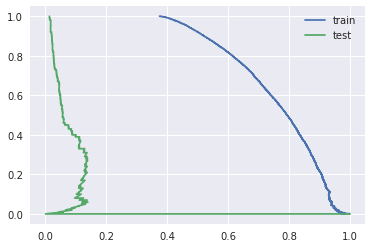

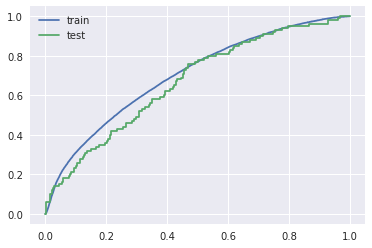

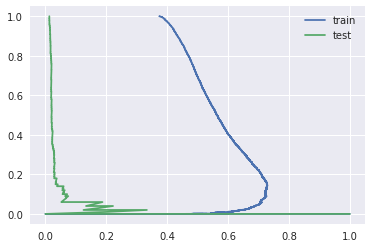

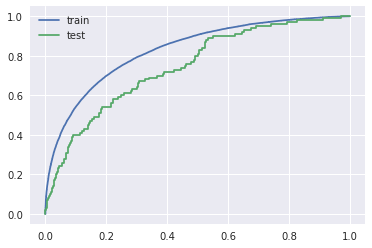

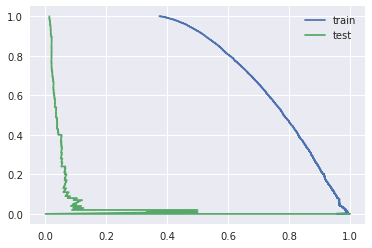

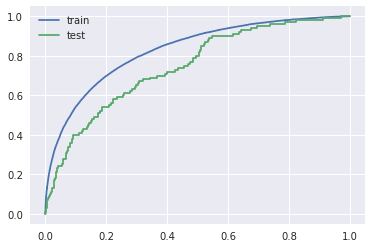

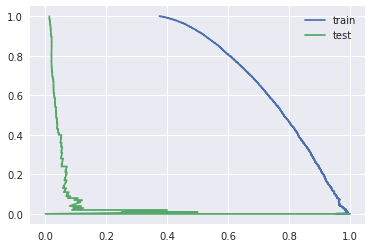

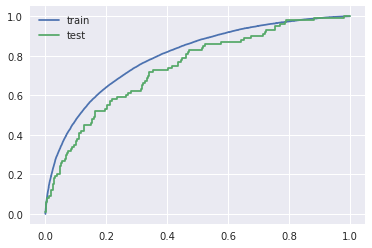

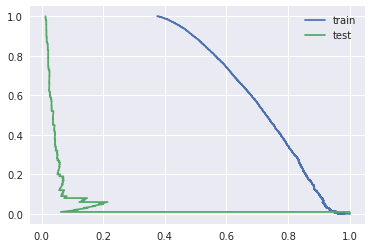

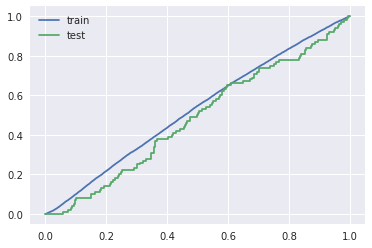

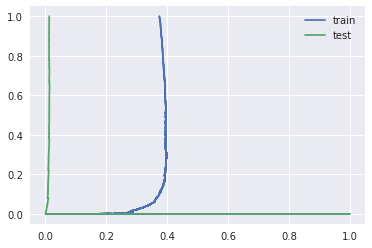

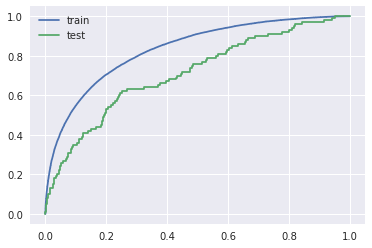

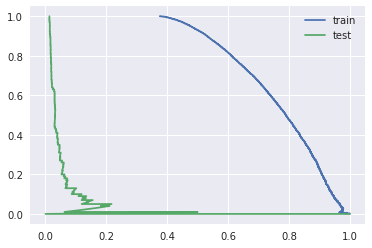

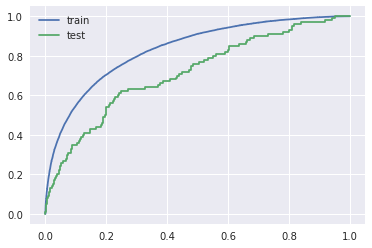

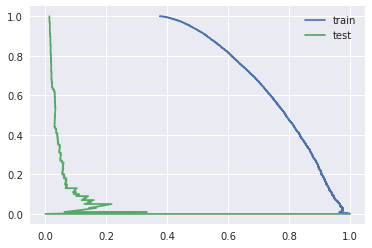

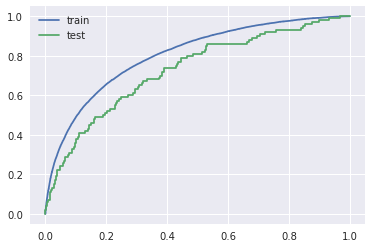

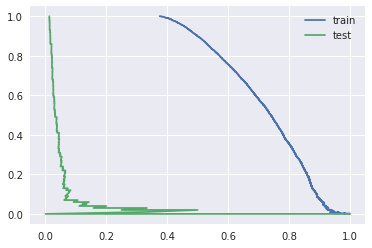

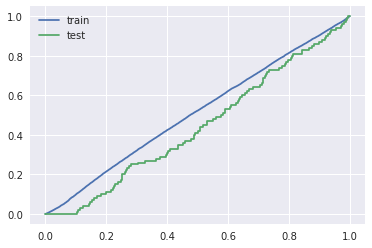

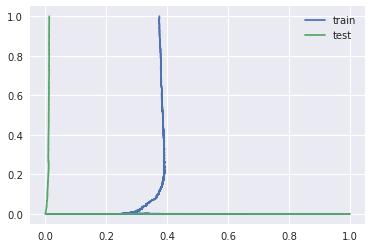

In [401]:
D = 8192
for GAMMA in [1e-1, 1.0, 1e4, 1e6]:
    np.random.seed(0)
    W = np.random.randn(D,8*4) * GAMMA
    switch_output_to_terminal()
    %time XLiftTrain_gpu = multigpu.conv_multi_gpu(XTrain, W, feature_batch_size=4096, batch_size=1024, num_gpu=16, tag="train", loc="/mnt/tmp")
    %time XLiftTest_gpu = multigpu.conv_multi_gpu(XTest, W, feature_batch_size=4096, batch_size=1024, num_gpu=16, tag="val", loc="/mnt/tmp")
    switch_output_to_notebook()
    features.append((GAMMA, SEQ_SIZE, XLiftTrain_gpu, XLiftTest_gpu))
    for reg in [1e-8, 1e5, 1e7, 1e9]:
        feats_to_use = 8192
        print("FEATS: {0}".format(feat_to_use))
        train_roc, test_roc, train_pr, test_pr, train_prauc, test_prauc, yPredTrain, yPredTest = \
        trainAndEvaluatePrimalModel(XLiftTrain_gpu[:, :feat_to_use], \
                                    XLiftTest_gpu[:, :feat_to_use], \
                                    labelsTrain,labelsTest, \
                                    reg=reg)
        train = plt.plot(train_roc[0], train_roc[1], label="train")
        test = plt.plot(test_roc[0], test_roc[1], label="test")
        train_roc = metrics.auc(train_roc[0], train_roc[1])
        test_roc = metrics.auc(test_roc[0], test_roc[1])
        plt.legend(handles=[train[0], test[0]])
        plt.figure()
        train_pr_curve = plt.plot(train_pr[0], train_pr[1], label="train")
        test_pr_curve = plt.plot(test_pr[0], test_pr[1], label="test")
        plt.legend(handles=[train_pr_curve[0], test_pr_curve[0]])
        plt.figure()
        print ("Train ROC ", train_roc)
        print ("Test ROC ", test_roc)
        print("Train AUPRC ", train_prauc)
        print("Test AUPRC ", test_prauc)
        result = {}
        result['gamma'] = GAMMA
        result['reg'] = reg
        result['weight'] = W
        result['feat'] = feat_to_use
        result['train_roc'] = train_roc
        result['test_roc'] = test_roc
        result['train_pr'] = train_pr
        result['test_pr'] = test_pr
        results.append(result)
    

In [397]:
len(labelsTrain)

63559

In [383]:
switch_output_to_terminal()
%time XLiftTrain_gpu = multigpu.conv_multi_gpu(XTrain, W, feature_batch_size=4096, batch_size=1024, num_gpu=16, tag="train", loc="/mnt/tmp")
%time XLiftTest_gpu = multigpu.conv_multi_gpu(XTest, W, feature_batch_size=4096, batch_size=1024, num_gpu=16, tag="val", loc="/mnt/tmp")
switch_output_to_notebook()

In [388]:
if (ARE_YOU_SURE):
    print("DELETING ALL RESULTS YOU HAVE 10 seconds to ctrl-c")
    time.sleep(10)
    results = []
    features = []
else:
    print("YOU ARE NOT SURE YOU DUMMY")

DELETING ALL RESULTS YOU HAVE 10 seconds to ctrl-c


In [405]:
results_df = pd.DataFrame(results)

/mnt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


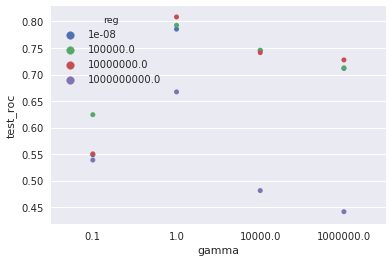

In [408]:
sns.stripplot(data=results_df, x="gamma", y="test_roc", hue="reg")

100

# EVERYTHING BELOW THIS IS TRASH

In [106]:
XLiftTest_gpu = np.ascontiguousarray(XLiftTest_gpu)
XLiftTrain_gpu = np.ascontiguousarray(XLiftTrain_gpu)

In [107]:
switch_output_to_notebook()

In [113]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
XLiftTrain_gpu_normalized = std.fit_transform(XLiftTrain_gpu)
XLiftTest_gpu_normalized = std.transform(XLiftTest_gpu)

(63559, 16384)
(8000, 16384)
X SHAPE  (63559, 16384)
Computing XTX
Done Computing XTX
Train acc 0.814235592127
Test acc 0.651375
Train ROC  0.914750741056
Test ROC  0.713062025316
Train AUPRC  0.877482509367
Test AUPRC  0.0311199306768
/mnt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


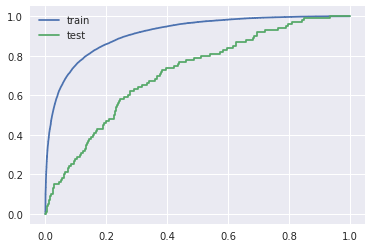

In [114]:
for reg in [1e-8]:
    train_roc, test_roc, train_pr, test_pr = trainAndEvaluatePrimalModel(XLiftTrain_gpu_normalized, XLiftTest_gpu_normalized, labelsTrain, labelsTest, reg=reg)
    train = plt.plot(train_roc[0], train_roc[1], label="train")
    test = plt.plot(test_roc[0], test_roc[1], label="test")
    train_roc = metrics.auc(train_roc[0], train_roc[1])
    test_roc = metrics.auc(test_roc[0], test_roc[1])
    print ("Train ROC ", train_roc)
    print ("Test ROC ", test_roc)
    print("Train AUPRC ", train_pr)
    print("Test AUPRC ", test_pr)
    plt.legend(handles=[train[0], test[0]])
    plt.figure()
    result = {}
    result['gamma'] = gamma
    result['reg'] = reg
    result['feat'] = D*2
    result['train_roc'] = train_roc
    result['test_roc'] = test_roc
    result['train_pr'] = train_pr
    result['test_pr'] = test_pr
    results.append(result)

In [165]:
normsTrain = np.linalg.norm(XLiftTrain_gpu, axis=1) 
normsTrain = (normsTrain * normsTrain) / (D*2)

In [166]:
normsTest = np.linalg.norm(XLiftTest_gpu, axis=1) 
normsTest = (normsTest * normsTest) / (D*2)

In [176]:
KTrain_rbf = KTrain.copy()
KTest_rbf = KTest.copy()
K_train_rbf = computeRBFGramMatrix(KTrain_rbf, normsTrain, normsTrain, gamma=1e-6)

In [177]:
K_test_rbf = computeRBFGramMatrix(KTest_rbf, normsTrain, normsTest, gamma=1e-6)

KeyboardInterrupt: 

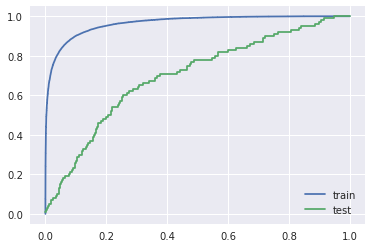

In [178]:
for reg in [1e-5, 1e-2]:
    print("REG IS {0}".format(reg))
    train_roc, test_roc, train_pr, test_pr = trainAndEvaluateDualModel(KTrain_rbf, KTest_rbf,labelsTrain, labelsTest, reg=reg)
    train = plt.plot(train_roc[0], train_roc[1], label="train")
    test = plt.plot(test_roc[0], test_roc[1], label="test")
    train_roc = metrics.auc(train_roc[0], train_roc[1])
    test_roc = metrics.auc(test_roc[0], test_roc[1])
    print ("Train ROC ", train_roc)
    print ("Test ROC ", test_roc)
    print("Train AUPRC ", train_pr)
    print("Test AUPRC ", test_pr)
    plt.legend(handles=[train[0], test[0]])
    plt.figure()
    result = {}
    result['gamma'] = gamma
    result['reg'] = reg
    result['feat'] = D*2
    result['train_roc'] = train_roc
    result['test_roc'] = test_roc
    result['train_pr'] = train_pr
    result['test_pr'] = test_pr
    results.append(result)

In [122]:
s = 100
xy = np.random.choice(KTrain.shape[0], s*2)
x = xy[:s]
y = xy[s:]
distances = []
for i in range(s):
    distances.append(np.linalg.norm(XLiftTrain_gpu[x[i]] - XLiftTrain_gpu[y[i]]))
    
print(np.median(distances))
    

array([58, 65, 59, ..., 71, 54, 33])

In [109]:
switch_output_to_terminal()

In [113]:
print("POOP")

In [162]:
normsTrain

array([ 0.00372616,  0.00321596,  0.00568051, ...,  0.00313798,
        0.00331705,  0.00348943])

In [163]:
normsTrain

array([ 0.00372616,  0.00321596,  0.00568051, ...,  0.00313798,
        0.00331705,  0.00348943])

In [164]:
KTrain

array([[ 488.39508057,  241.07281494,  332.5395813 , ...,  254.32060242,
         264.35955811,  217.09024048],
       [ 241.07281494,  421.52249146,  204.54374695, ...,  263.34185791,
         268.78985596,  286.53225708],
       [ 332.5395813 ,  204.54374695,  744.55651855, ...,  289.5970459 ,
         227.70883179,  163.11621094],
       ..., 
       [ 254.32060242,  263.34185791,  289.5970459 , ...,  411.30181885,
         251.61546326,  255.87879944],
       [ 264.35955811,  268.78985596,  227.70883179, ...,  251.61546326,
         434.77246094,  271.22183228],
       [ 217.09024048,  286.53225708,  163.11621094, ...,  255.87879944,
         271.22183228,  457.36700439]], dtype=float32)

In [179]:
XTrain

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [187]:
results_df = pd.DataFrame(results[:-3])

In [188]:
results_df["gamma"] = 1.0

In [195]:
print(results_df[:12][["train_roc", "train_pr", "test_roc", "test_pr"]].to_csv())

In [5]:
from sklearn.neighbors import NearestNeighbors

In [6]:
import numpy as np

In [198]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(XTrain)

In [ ]:
distances, indices = nbrs.kneighbors(XTest)

In [42]:
def cond(x):
    xtx = x.T.dot(x)
    v = np.linalg.eigh(xtx)
    return v[0][-1]/v[0][0]


In [93]:
XTrain

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [97]:
D = computeDistanceMatrix(XTrain, XTrain)

In [101]:
variances = np.var(D, axis=0)

array([[  1.13686838e-13,   4.38000000e+02,   4.36000000e+02, ...,
          4.58000000e+02,   4.48000000e+02,   4.64000000e+02],
       [  4.38000000e+02,   1.13686838e-13,   4.30000000e+02, ...,
          4.62000000e+02,   4.44000000e+02,   4.28000000e+02],
       [  4.36000000e+02,   4.30000000e+02,   1.13686838e-13, ...,
          4.36000000e+02,   4.64000000e+02,   4.74000000e+02],
       ..., 
       [  4.58000000e+02,   4.62000000e+02,   4.36000000e+02, ...,
          1.13686838e-13,   4.50000000e+02,   4.66000000e+02],
       [  4.48000000e+02,   4.44000000e+02,   4.64000000e+02, ...,
          4.50000000e+02,   1.13686838e-13,   4.68000000e+02],
       [  4.64000000e+02,   4.28000000e+02,   4.74000000e+02, ...,
          4.66000000e+02,   4.68000000e+02,   1.13686838e-13]])

In [116]:
pd.DataFrame(results)

,feat,gamma,reg,test_pr,test_roc,train_pr,train_roc
0,16384,<built-in method gamma of mtrand.RandomState o...,1.000000e-08,0.017076,0.545761,0.491743,0.633032
1,16384,<built-in method gamma of mtrand.RandomState o...,1.000000e-08,0.017076,0.545761,0.491743,0.633032
2,16384,<built-in method gamma of mtrand.RandomState o...,1.000000e-08,0.017076,0.545761,0.491743,0.633032
3,16384,1000,1.000000e-08,0.030622,0.711927,0.875040,0.912846
4,16384,1000,1.000000e+07,0.046951,0.750546,0.811394,0.869284
5,16384,1000,1.000000e+06,0.035408,0.730208,0.866936,0.906836
6,16384,1000,1.000000e+08,0.034768,0.718104,0.649175,0.767184
7,16384,<built-in method gamma of mtrand.RandomState o...,1.000000e-08,0.031120,0.713062,0.877483,0.914751


'1.11.3'

In [390]:
results

[]